In [11]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from tqdm import tqdm
import os

import cv2
import keras
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Training_Data.csv')

In [3]:
df.head()

Image_name  carb.lag.delta  toby.lag.delta
0  PIL-1_3dayLBCR-1              19               4
1  PIL-1_3dayLBCR-2              19               4
2  PIL-1_3dayLBCR-3              19               4
3  PIL-1_3dayLBCR-4              19               4
4  PIL-2_3dayLBCR-1              -2              14

In [4]:
len(df['carb.lag.delta'].unique())

30

In [5]:
df.shape

(369, 3)

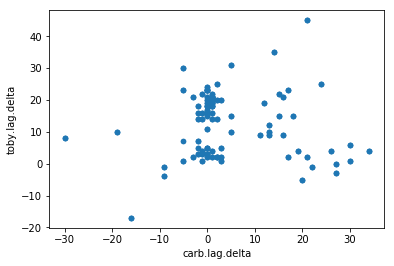

In [6]:
df.plot.scatter(x='carb.lag.delta', y='toby.lag.delta')

In [7]:
targets_series = pd.Series(df['carb.lag.delta'])
one_hot = pd.get_dummies(targets_series, sparse=True)
one_hot_labels_1 = np.asarray(one_hot)
targets_series = pd.Series(df['toby.lag.delta'])
one_hot = pd.get_dummies(targets_series, sparse=True)
one_hot_labels_2 = np.asarray(one_hot)

In [39]:
img_size = 299

x_train = []
y_train_1 = []
y_train_2 = []

In [40]:
i = 0 
for id, anti1, anti2 in tqdm(df.values):
    path = 'Data/{}.jpg'.format(id)
    if os.path.isfile(path):
        img = cv2.imread(path)
        label1 = one_hot_labels_1[i]
        label2 = one_hot_labels_2[i]
        x_train.append(cv2.resize(img, (img_size, img_size)))
        y_train_1.append(label1)
        y_train_2.append(label2)
    i += 1

100%|██████████| 369/369 [07:29<00:00,  1.22s/it]


In [41]:
len(x_train)

254

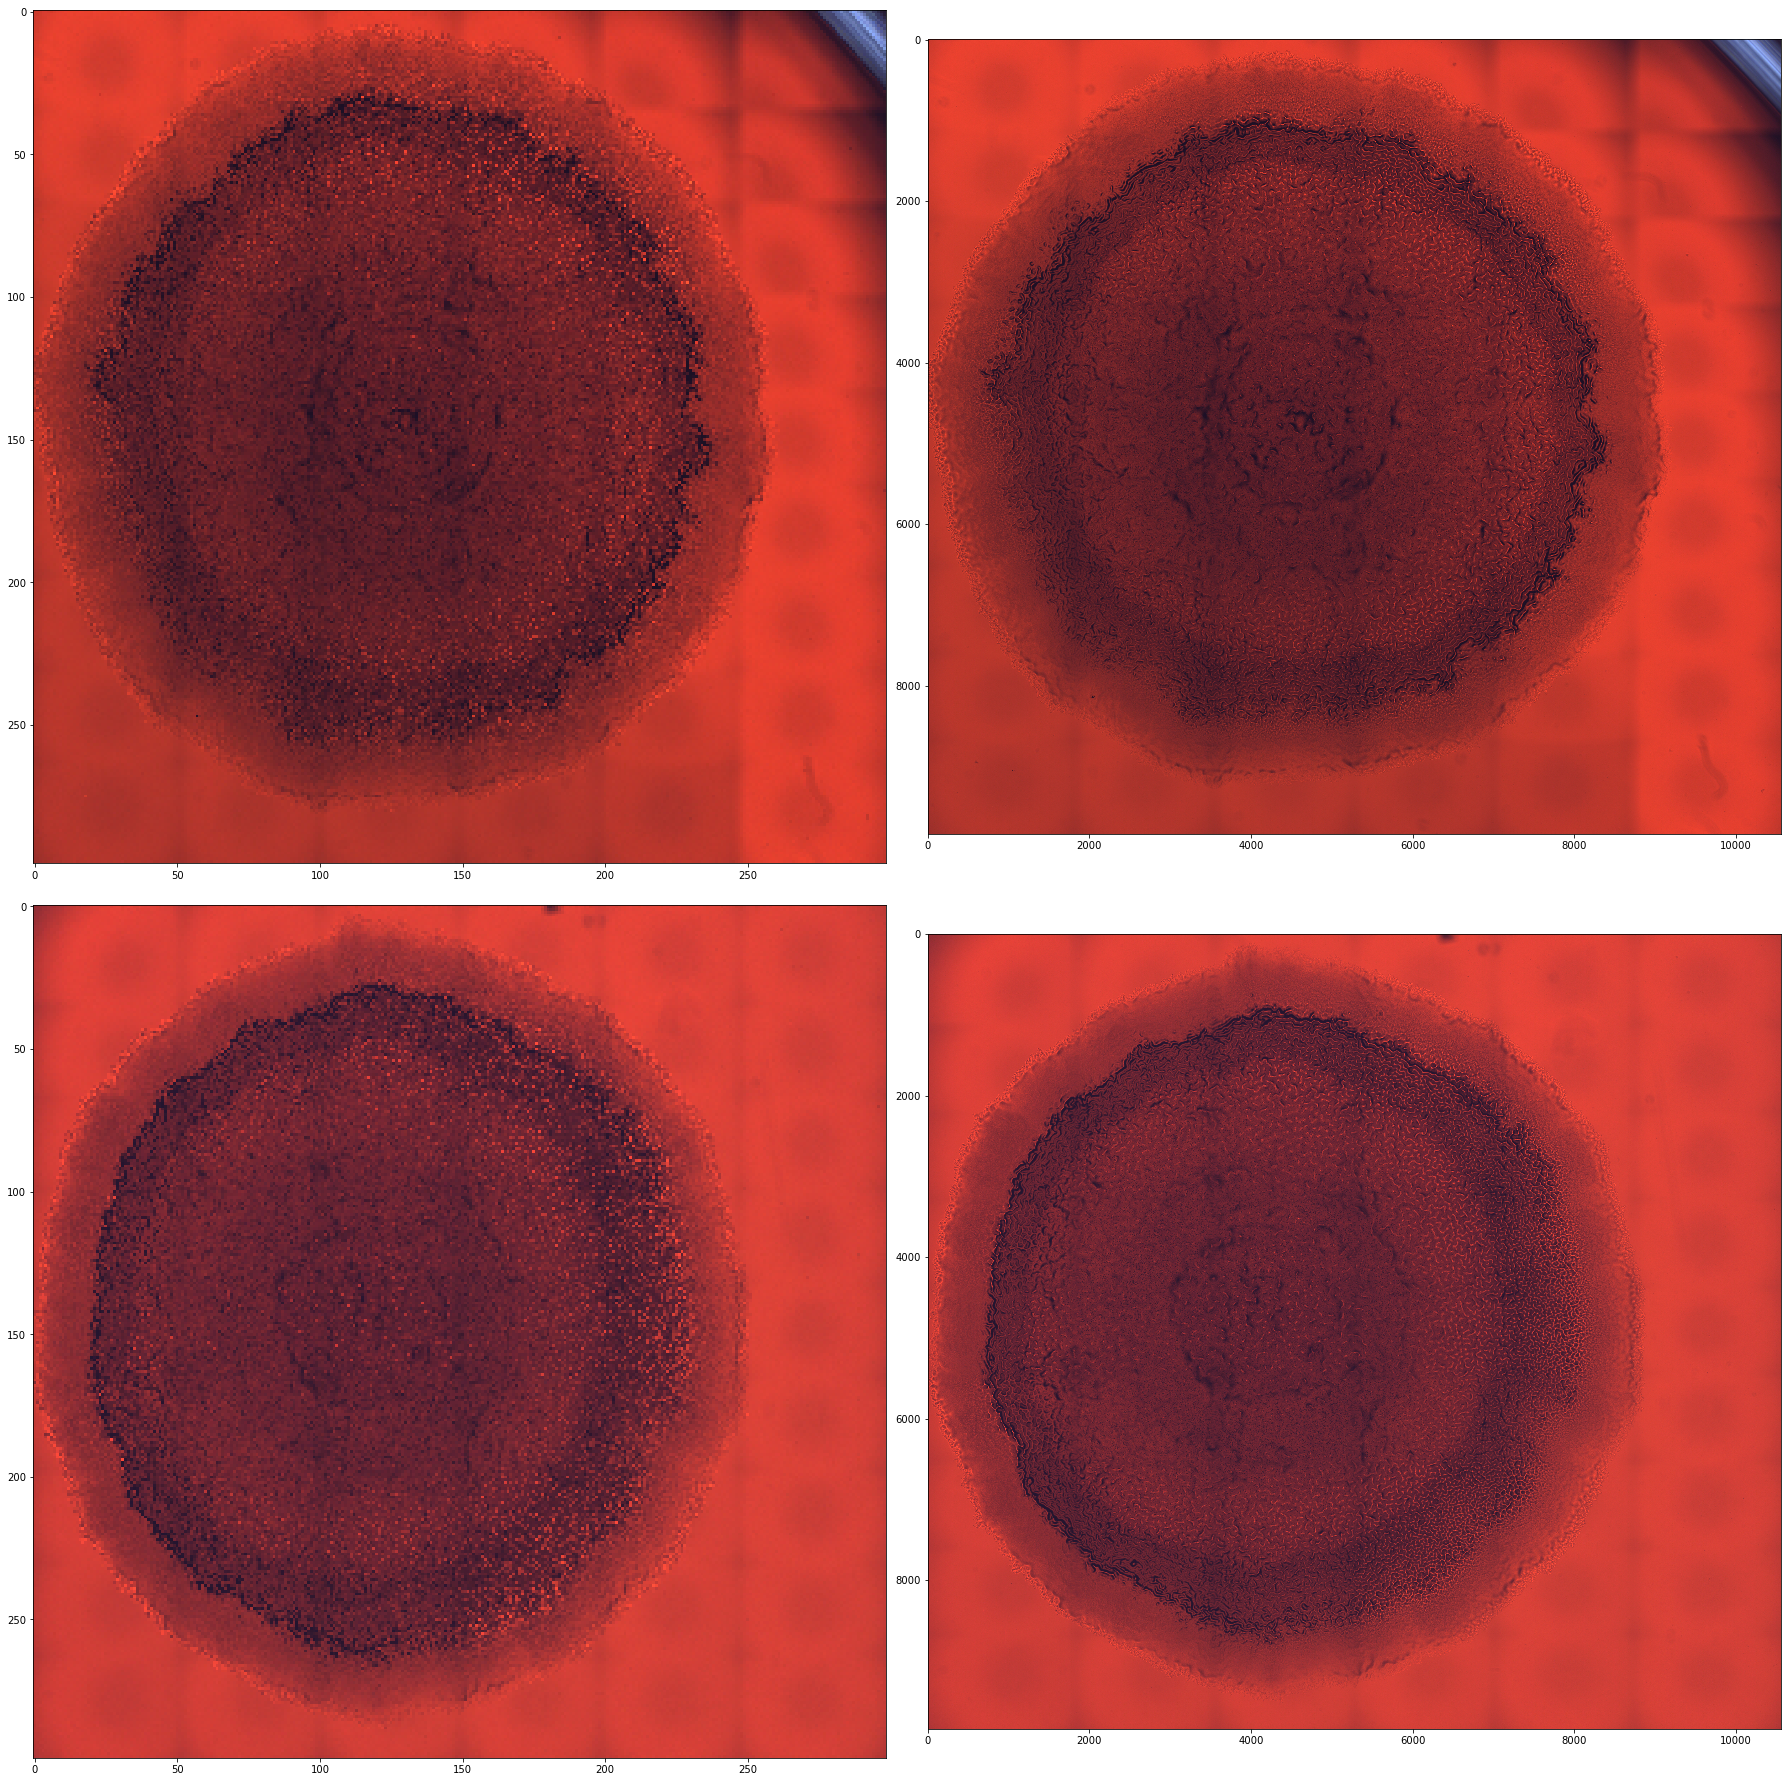

In [47]:
fig, axarr = plt.subplots(2, 2, figsize=(25, 25))
fig.tight_layout()
axarr[0, 0].imshow(cv2.cvtColor(x_train[0], cv2.COLOR_RGB2BGR)) 
axarr[0, 1].imshow(cv2.cvtColor(cv2.imread('Data/{}.jpg'.format(df['Image_name'][0])), cv2.COLOR_RGB2BGR)) 
axarr[1, 0].imshow(cv2.cvtColor(x_train[1], cv2.COLOR_RGB2BGR)) 
axarr[1, 1].imshow(cv2.cvtColor(cv2.imread('Data/{}.jpg'.format(df['Image_name'][1])), cv2.COLOR_RGB2BGR)) 

In [48]:
y_train_1_raw = np.array(y_train_1, np.uint8)
y_train_2_raw = np.array(y_train_2, np.uint8)
x_train_raw = np.array(x_train, np.float32) / 255

In [40]:
print(x_train_raw.shape)
print(y_train_1_raw.shape)
print(y_train_2_raw.shape)

(405, 90, 90, 3)
(405, 30)
(405, 34)


In [55]:
num_class = y_train_1_raw.shape[1]

In [56]:
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train_raw, y_train_1_raw, test_size=0.3, random_state=1)

In [57]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Add a new top layer
x = base_model.output
x = Flatten()(x)
predictions = Dense(num_class, activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# First: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]

In [58]:
Y_train.shape

(283, 30)

In [59]:
model.fit(X_train, Y_train, epochs=1, validation_data=(X_valid, Y_valid), verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 283 samples, validate on 122 samples
Epoch 1/1
283/283 [==============================] - 42s 148ms/step - loss: 3.3141 - acc: 0.0459 - val_loss: 2.7204 - val_acc: 0.1230
